# Tutorial for analyzing instrumental learning data in HDDM with the HDDMrl module
This is a tutorial for using the HDDMrl module in HDDM to analyse two-alternative forced choice instrumental learning data. The module uses the the reinforcement learning drift diffusion model (RLDDM), which is a reinforcement learning model that captures choices between two alternatives in instrumental learning as a drift diffusion process. It estimates trial-by-trial drift rate as a scaled difference in expected rewards (expected reward for upper bound alternative minus expected reward for lower bound alternative). Expected rewards are updated with a delta learning rule using a single or signed learning rate(s). The model also includes the standard DDM-parameters. The RLDDM is described in detail in [Pedersen, Frank & Biele (2017).](http://ski.clps.brown.edu/papers/PedersenEtAl_RLDDM.pdf)

## OUTLINE 

[1. Background](#1.-Background) <br>
[2. Installing the module](#2.-Installing-the-module) <br>
[3. How it works](#3.-How-it-works) <br>
[4. Structuring data](#4.-Structuring-data) <br>
[5. Running basic model](#5.-Running-basic-model) <br>
[6. Check results](#6.-Check-results) <br>
[7. Posterior predictive checks](#7.-Posterior-predictive-checks)<br>
[8. Parameter recovery](#8.-Parameter-recovery)<br>
[9. Separate learning rates for positive and negative prediction errors](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors)<br>
[10. depends_on vs. split_by](#10.-depends_on-vs.-split_by)


## 1. Background
Traditional RL models typically assume static decision processes (e.g. softmax), and the DDM typically assumes static decision variables (stimuli are modeled with the same drift rate across trials). The RLDDM combines dynamic decision variables from RL and dynamic choice process from DDM by assuming trial-by-trial drift rate that depends on the difference in expected rewards, which are updated on each trial by a rate of the prediction error dependent on the learning rate. The potential benefit of the RLDDM is thus to gain a better insight into decision processes in instrumental learning by also accounting for speed of decision making.

## 2. Installing the module
The RLDDM module is currently in a beta version, so to install you would need to use pip instead of conda. If you have HDDM installed then the following command should get you access to the module while still being able to use HDDM and HDDMRegressor:

pip install -U --no-deps git+https://github.com/hddm-devs/hddm@rlddm

And the following applies for when the beta-version is merged into HDDM:
The master version of HDDM includes the RLDDM module, so to get started just update or install HDDM through conda :<br>
conda update HDDM <br>
OR <br>
conda install HDDM <br>
See help on installing-issues here and here.

## 3. How the RLDDM works
The main idead of the RLDDM is that choices in instrumental learning can be explained as an accumulation-to-bound process. And that drift rate in the DDM captures the difference in expected reward between options. So if expected reward is high for one option and low for the other then the decision maker is likely to choose the option with highest exepcted reward, which would be reflected in the drift rate. And that expected reward for the chosen option is updated depending on the reinforcement received, which then feeds into the drift rate on the subsequent choice. <br><br>
__drift rate on each trial depends on difference in expected rewards:__ <br>
drift rate = (q_up - q_low) * scaling <br><br>
_the scaling parameter describes the weight to put on the difference in q-values._<br><br>
__expeceted reward for chosen option is updated according to delta learning rule:__ <br>
q_chosen = q_chosen + alpha * (feedback-q_chosen) <br><br>
So in principle all you need is the wiener first passage time likelihood-function. The reason why HDDM is useful (and hence also HDDMrl) is because it automates the process of setting up your model, which tend to be very time consuming. So after structuring the data it is simple to run a model with HDDMrl. In particular it separates subjects and conditions (using the split_by-column, see next section) so that the updating process works correctly. 

## 4. Structuring data
The HDDMrl module was created to make it easier to model instrumental learning data with the RLDDM. If you are familiar with using HDDM it shouldn't be a big step to start using HDDMrl. If you're not, I suggest you start with the [tutorial for HDDM](http://ski.clps.brown.edu/hddm_docs/index.html) first. Running HDDMrl does require a few extra steps compared to HDDM, and because the model includes more variables that also tend to be correlated (typically learning rate and scaling on drift rate) it is even more important to assess model fit, which will be covered below. Here are the most important steps for structuring your dataframe:
1. Sort trials in ascending order within subject and condition, to ensure proper updating of expected rewards.
2. Include a column called __'split_by'__ which identifies the different conditions (__as integers__), again to ensure updating will work properly. 
3. Code the response column with stimulus-coding. Although stimulus-coding and accuracy-coding often are the same in instrumental learning it is important that the boundaries are the same within a condition, because expected rewards are linked to the thresholds/boundaries.
4. __feedback__-column. This should be the reward received for the chosen option on each trial.
5. __q__. Initialization of q-values is something that can improve model fit quite a bit. To allow the user to set their own initial values we therefore require that the dataframe includes a column called q. Only the first value for each split will be used, because the expected value will be updated. So this is not the most elegant method of allowing users to set inital value for expected rewards, but it works for now.

#### Required columns in data:
* __rt__: in seconds, same as in HDDM
* __response__: 0 or 1. defines chosen stimulus, not accuracy (although that would probably always be the same given how we set it up now
* __split_by__: needs to be an integer. Split_by defines conditions that should have the same parameter within subject, e.g. you could assume the same learning rate across conditions in the PST but you need to split the trials in order to ensure proper updating of expected rewards.
* __subj_idx__: same as in HDDM, but even more important here because it is used to split trials
* __feedback__: feedback on the current trial. can be any value.
* __q__: used to initialize expected rewards. can be any value. 

## 5. Running basic model
To illustrate how to run the model we will use pre-collected data from the learning phase of the probabilistic selection task (PST). The data are taken from [Frank, Moustafa, Haughey, Curran & Hutchinson (2007)](http://ski.clps.brown.edu/papers/FrankEtAl_PNAS.pdf). During the learning phase of the PST subjects choose between two  stimuli presented as Hiragana-letters (here represented as letters from the latin alphabet). There are three conditions with different probabilities of receiving reward (feedback=1) and non-reward (feedback=0). In the AB condition A is rewarded with 80% probability, B with 20%. In the CD condition C is rewarded with 70% probability and D with 30%, while in the EF condition E is rewarded with a 60% probability and F with 40%. The dataset is included in the data-folder in your installation of HDDM.

In [1]:
#import
import pandas as pd
import numpy as np
import hddm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/madslundpedersen/anaconda/envs/UpdatedEnvironment/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
#load data
data = hddm.load_csv('data/rlddm_data.csv')
#check structure
data.head()

,subj_idx,response,cond,rt,trial,split_by,feedback,q,bin_trial
0,42,0.0,CD,1.255,1.0,1,0.0,0.5,0
1,42,1.0,EF,0.778,1.0,2,0.0,0.5,0
2,42,1.0,AB,0.647,1.0,0,1.0,0.5,0
3,42,1.0,AB,0.750,2.0,0,1.0,0.5,0
4,42,0.0,EF,0.772,2.0,2,1.0,0.5,0


In [4]:
#run the model by calling hddm.HDDMrl (instead of hddm.HDDM for normal model)
m = hddm.HDDMrl(data)
#set sample and burn-in
m.sample(2000,burn=1000,dbname='traces.db',db='pickle')
#print stats to get an overview of posterior distribution of estimated parameters
m.print_stats()

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2001 of 2000 complete in 643.9 sec

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                    mean         std       2.5q        25q        50q        75q     97.5q       mc err
a                1.85394   0.0648854    1.72953    1.80842    1.85272    1.89635   1.98882   0.00272744
a_std           0.439379   0.0533458   0.353223   0.401508   0.434306   0.473127  0.564993   0.00237314
a_subj.1         2.09501   0.0609127    1.97879    2.05272    2.09387    2.13484   2.22338   0.00287129
a_subj.2         1.88682    0.130905    1.66931    1.79575    1.87289    1.96582     2.187   0.00482303
a_subj.3         2.04607    0.090463    1.87566    1.98052    2.04347    2.10927    2.2173   0.00418521
a_subj.4          2.1031   0.0505285    2.00359    2.07048    2.10012    2.13854   2.20418   0.00178995
a_subj.5         1.50292   0.0671762    1.37619    1.45582    1.50135    1.55006    1.6369   0.00286602
a_subj.6         2.47548   0.0921326    2.29747    2.41592    2.47374    2.53237   2.66309   0.00409163
a_subj.7         2.03537    0.149595    1.76956    1.92612    2.

In [7]:
traces = m.get_traces()
traces.to_csv('data/traces.csv')

__There are a few things to note that are different from the normal HDDM model.__ <br>
First of all, the model is between 2-3 times slower than the regular HDDM. This is due to additional calculations of q-values and having extra parameter(s) for learning rate. <br>
Second, the estimated learning rate does not necessarily fall between 0 and 1. This is because it is estimated as a normal distribution and then transformed by an inverse logit function to 0<alpha<1. So to interpret alpha you have to transform the samples in the trace back with np.exp(alpha)/(1+np.exp(alpha)). And if you estimate separate learning rates for positive and negative prediction errors ([see here](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors)) then you get learning rate for negative prediction errors with np.exp(alpha)/(1+np.exp(alpha)) and positive prediction errors with np.exp(alpha+dual_alpha)/(1+np.exp(alpha+dual_alpha)).<br>
Third, the v-parameter in the output is the scaling factor that is multiplied to the difference in q-values, so it is not the actual drift rate. 

## 6. Check results

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting alpha
Plotting alpha_std


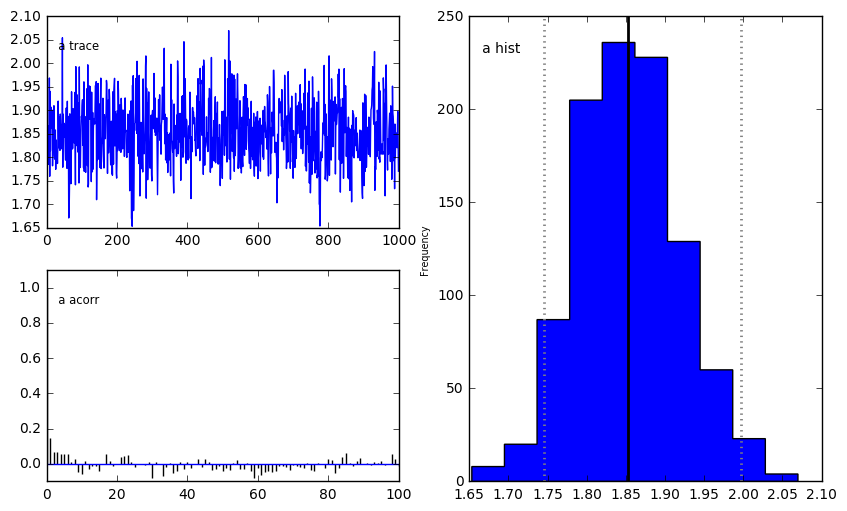

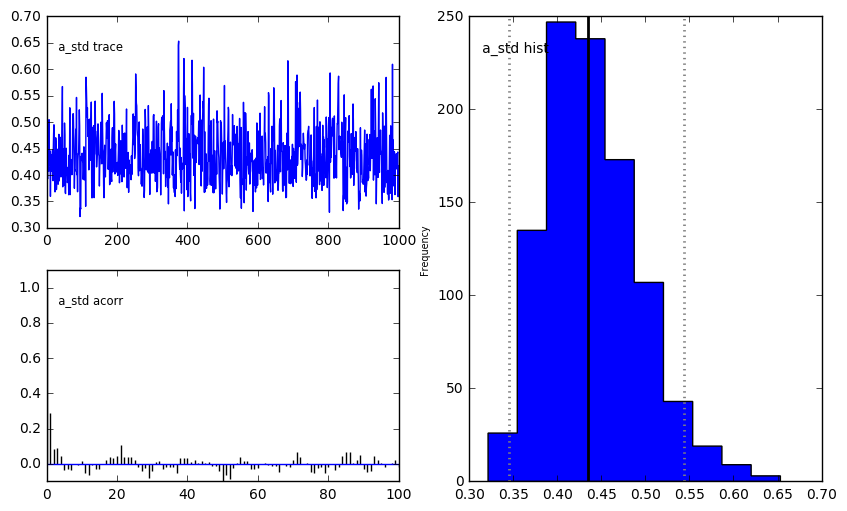

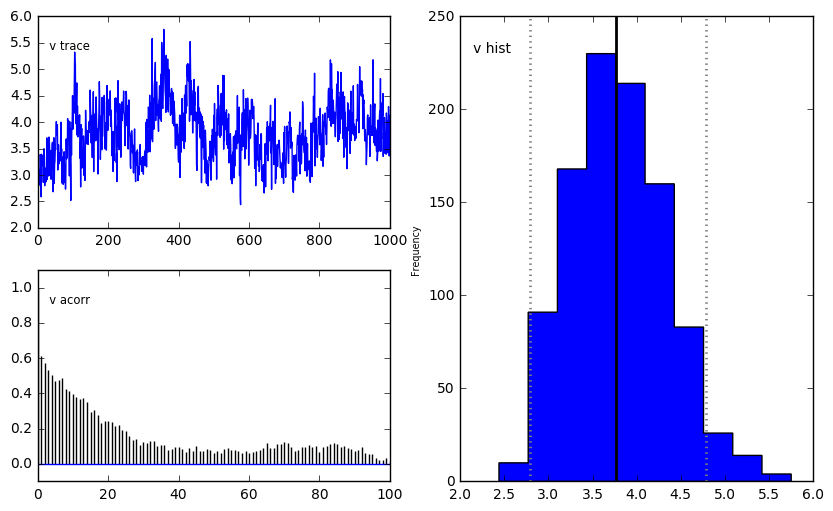

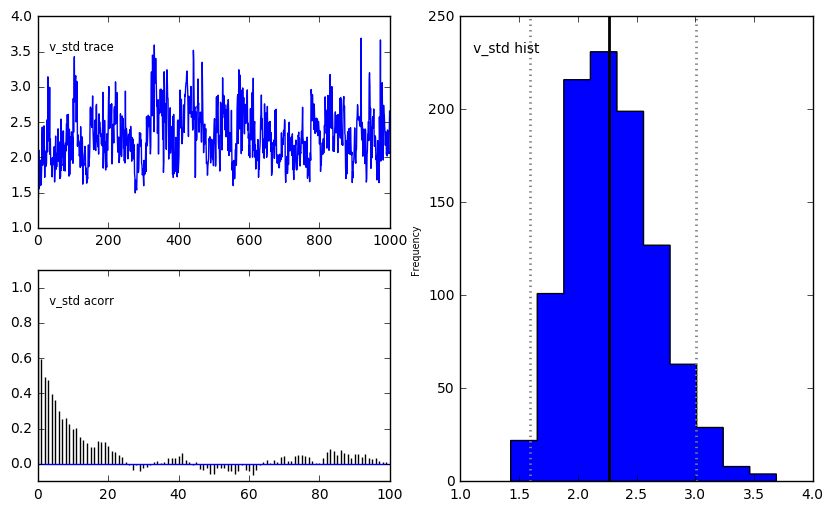

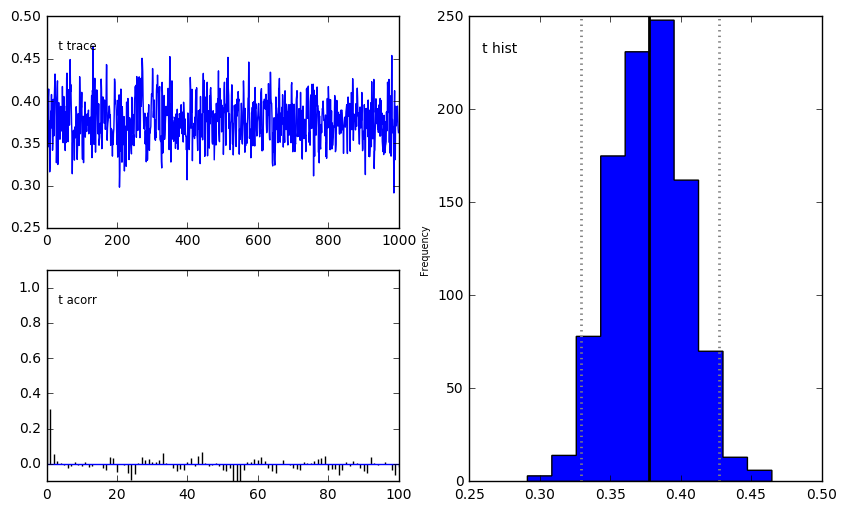

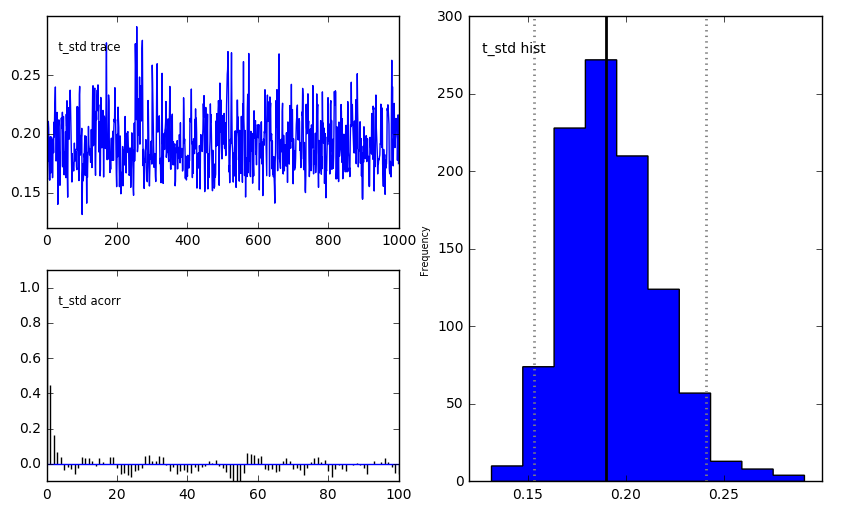

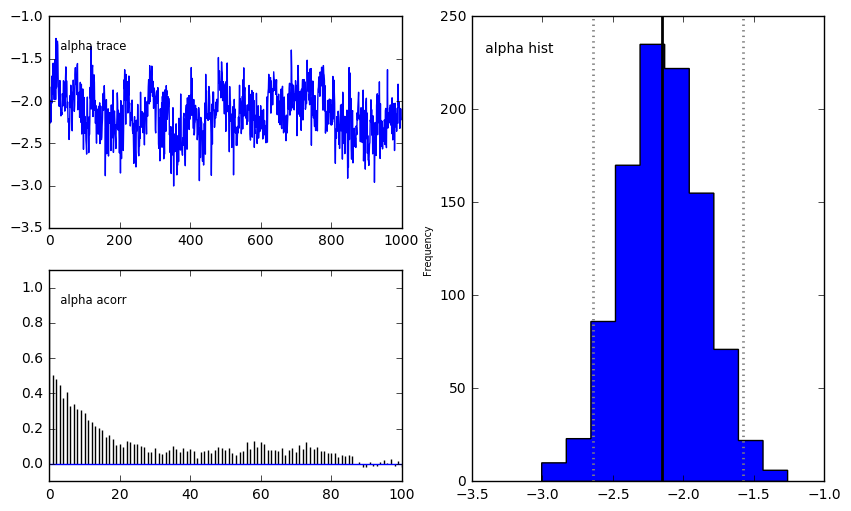

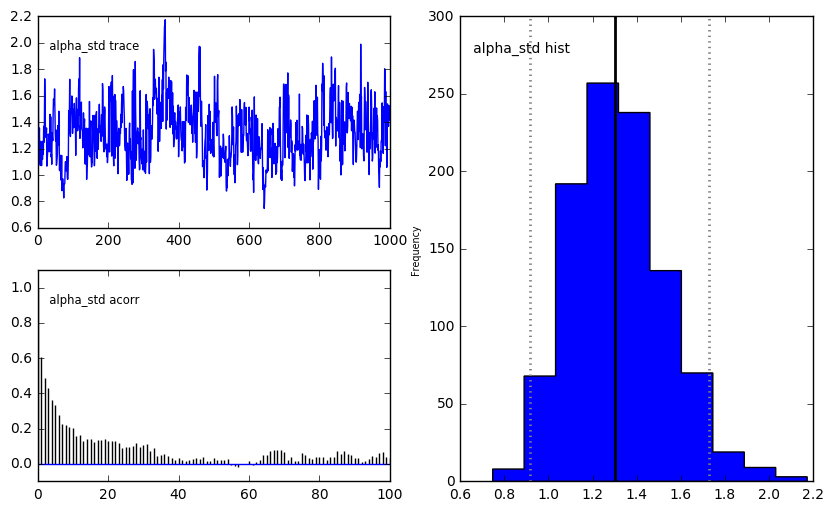

In [5]:
# plot the posteriors of parameters 
m.plot_posteriors()

__The mixing of the posterior distribution looks good although there is some small issues with autocorrelation for alpha and v.__

### Joint posterior distribution
Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that they explain the same effects, in particular if there is a negative correlation. As the following plot shows there is generally low correlation across all combinations of parameters except for the negative correlation between learning rate and the scaling factor (-0.42), similar to what's usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule.

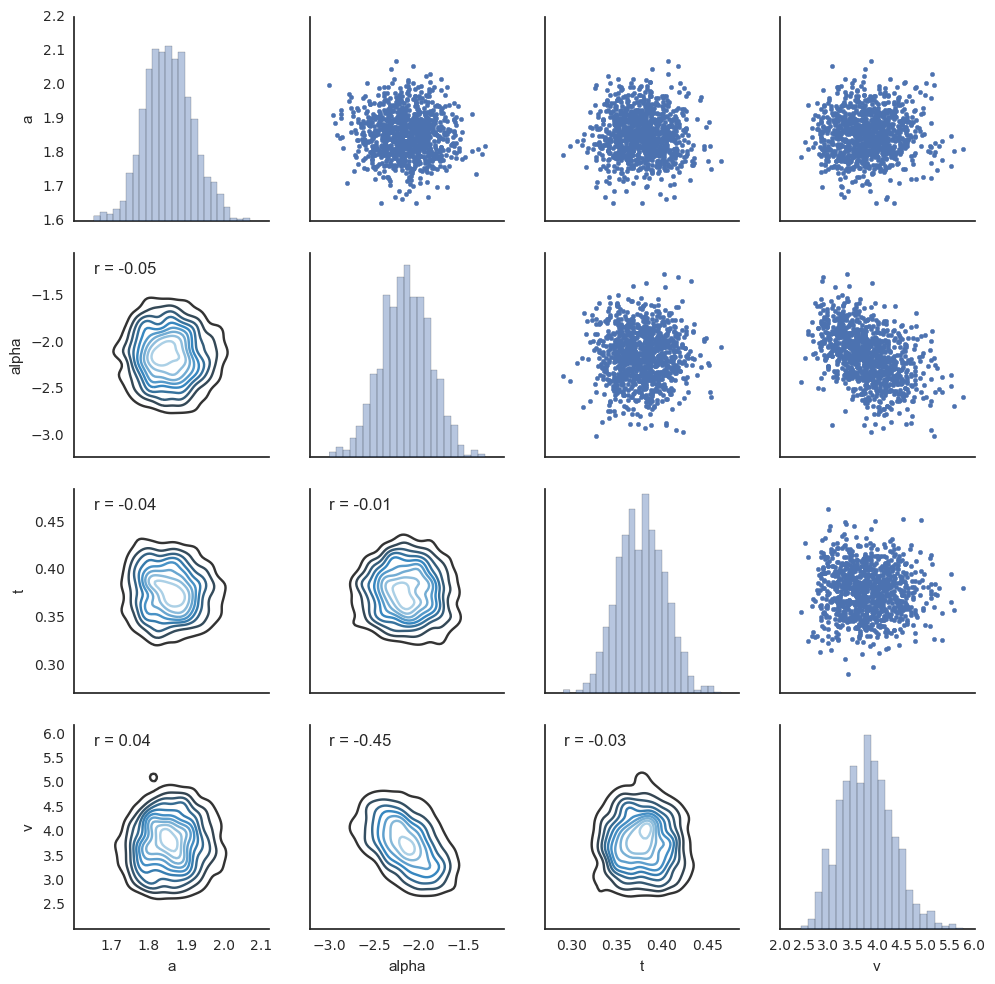

In [6]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

alpha, t, a, v = m.nodes_db.node[['alpha', 't', 'a','v']]
samples = {'alpha':alpha.trace(),'t':t.trace(),'a':a.trace(),'v':v.trace()}
samp = pd.DataFrame(data=samples)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')

### Convergence of chains
The Gelman-Rubin statistic is a test of whether the chains in the model converges. The Gelman-Ruben statistic measures the degree of variation between and within chains. Values between 1 and 1.1 indicate converegence and that there is small variation between chains, i.e. that they end up as the same distribution across chains. To run this you need to run multiple models and combine them:

In [6]:
# estimate convergence
from kabuki.analyze import gelman_rubin

models = []
for i in range(5):
    m = hddm.HDDMrl(data=data)
    m.find_starting_values()
    m.sample(2000, burn=1000)
    models.append(m)

gelman_rubin(models)

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 634.3 sec

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


 [-----------------100%-----------------] 2000 of 2000 complete in 644.5 sec

{'a': 1.0037355128097079,
 'a_std': 1.0010774882131521,
 'a_subj.1': 0.99956663815152247,
 'a_subj.10': 0.99919318389497558,
 'a_subj.11': 0.99912140350787348,
 'a_subj.12': 0.99987847944539021,
 'a_subj.13': 1.0005830660749004,
 'a_subj.14': 1.0032819638623489,
 'a_subj.16': 1.000322990283586,
 'a_subj.17': 1.0002305535514391,
 'a_subj.18': 1.0030501093203428,
 'a_subj.19': 1.0037349831092488,
 'a_subj.2': 1.001070450552034,
 'a_subj.20': 1.0000272703701201,
 'a_subj.21': 1.0022541323899652,
 'a_subj.22': 1.0011960702090292,
 'a_subj.23': 1.0019247406185623,
 'a_subj.24': 1.0016820583751116,
 'a_subj.26': 1.0012521311143818,
 'a_subj.28': 1.0003152056020335,
 'a_subj.3': 1.0034980396075404,
 'a_subj.32': 1.0014382562088391,
 'a_subj.33': 1.000839612580122,
 'a_subj.34': 1.0067251211768624,
 'a_subj.35': 1.0057069072922744,
 'a_subj.36': 1.0008014581041746,
 'a_subj.39': 0.99947311585681864,
 'a_subj.4': 0.99937045171467775,
 'a_subj.41': 1.0022369893745062,
 'a_subj.42': 0.99966360298

The output indicates that all parameters converged, as none of them are above 1.1. It is important to always run this test, especially for more complex models ([as with separate learning rates for positive and negative prediction errors](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors)).

## 7. Posterior predictive checks

An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

### extract traces
The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) for all of the estimated group and subject parameters (column).

In [7]:
traces = m.get_traces()
traces.head()

,a,a_std,a_subj.1,a_subj.10,a_subj.11,a_subj.12,a_subj.13,a_subj.14,a_subj.16,a_subj.17,...,v_subj.6,v_subj.63,v_subj.66,v_subj.68,v_subj.7,v_subj.71,v_subj.75,v_subj.8,v_subj.80,v_subj.95
0,1.849934,0.444942,2.035121,1.714317,2.394632,1.901230,1.596900,1.844396,2.416394,1.656279,...,4.872286,1.837720,2.200596,4.470781,7.782909,1.620122,3.208018,2.700788,2.162628,2.813686
1,1.762588,0.354635,2.066232,1.371853,2.229934,1.982600,1.882679,1.774927,2.424026,1.549013,...,4.924610,2.043590,1.787470,1.669426,6.179842,1.151416,3.129437,2.759778,1.280568,3.563675
2,1.817953,0.363220,2.047331,1.523026,2.490254,1.958330,1.851843,2.271407,2.483275,1.407691,...,7.000164,1.550040,2.959871,2.913574,5.422789,1.047530,3.894900,2.867483,1.485590,2.804540
3,1.860085,0.483771,2.065076,1.547836,2.220644,1.761323,1.918907,2.187600,2.458225,1.376486,...,6.713818,2.273836,2.618469,3.000820,5.138759,1.171040,3.930207,2.701413,1.370011,3.129162
4,1.882127,0.404294,2.054349,1.427988,2.198051,2.022572,1.734033,2.051573,2.439769,1.505615,...,5.947031,1.297143,2.506046,3.191430,4.753777,1.352630,3.816969,2.525065,1.138618,3.235954


### simulating data
__Now that we have the traces the next step is to simulate data using the estimated parameters. The RLDDM includes a function to simulate data. Here's an example of how to use the simulation-function for RLDDM using the following input:__ <br>
a = decision threshold <br>
t = non-decision time <br>
alpha = learning rate <br>
scaler = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate <br>
p_upper = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0 <br>
p_lower = the probability of reward for the option represented by the lower boundary. <br>
subjs = number of subjects to simulate data for. <br>
split_by = define the condition which makes it easier to append data from different conditions. <br>
size = number of trials per subject. <br>

In [8]:
hddm.generate.gen_rand_rlddm_data(a=1,t=0.3,alpha=0.2,scaler=2,p_upper=0.8,p_lower=0.2,subjs=1,split_by=0,size=10)

,q_up,q_low,sim_drift,response,rt,feedback,subj_idx,split_by,trial
0,0.500000,0.500000,0.000000,1.0,0.526962,1.0,0,0,0
1,0.646684,0.500000,0.310651,1.0,0.377962,1.0,0,0,1
2,0.750336,0.500000,0.530167,0.0,-0.606962,1.0,0,0,2
3,0.750336,0.646684,0.219516,1.0,1.005962,0.0,0,0,3
4,0.530211,0.646684,-0.246670,0.0,-0.640962,0.0,0,0,4
5,0.530211,0.456967,0.155117,0.0,-0.434962,0.0,0,0,5
6,0.530211,0.322907,0.439032,0.0,-0.448962,0.0,0,0,6
7,0.530211,0.228176,0.639655,1.0,0.490962,1.0,0,0,7
8,0.668032,0.228176,0.931536,0.0,-0.576962,1.0,0,0,8
9,0.668032,0.454605,0.452000,0.0,-0.752962,0.0,0,0,9


__How to interpret columns in the resulting dataframe__ <br>
q_up = expected reward for option represented by upper boundary <br>
q_low = expected reward for option represented by lower boundary <br>
sim_drift = the drift rate for each trial calculated as: (q_up-q_low)*scaler <br>
response = simulated choice <br>
rt = simulated response time <br>
feedback = observed feedback for chosen option <br>
subj_idx = subject id (starts at 0) <br>
split_by = condition as integer <br>
trial = current trial (starts at 0) <br>

### Simulate data with estimated parameter values
Now that we know how to extract traces and simulate data we can combine this to create a dataset similar to our observed data. This process is currently not automated but the following is an example code using the dataset we analyzed above. 

In [8]:
#create empty dataframe to store simulated data
sim_data = pd.DataFrame()
#load traces
traces = hddm.load_csv('data/traces.csv')
#loop through all subjects in observed data
for s in data.subj_idx.unique():
    #create empty dataframe to store simulated data for subject
    sub_data = pd.DataFrame()
    #get number of trials for each condition
    size0 = len(data[(data['subj_idx']==s) & (data['split_by']==0)].trial.unique())
    size1 = len(data[(data['subj_idx']==s) & (data['split_by']==1)].trial.unique())
    size2 = len(data[(data['subj_idx']==s) & (data['split_by']==2)].trial.unique())
    #decide how many times to repeat simulation process. repeating this multiple times is generally recommended as it better captures the uncertainty in the posterior distribution
    #for simplicity we only do this once in this example.
    for i in range(1,2):
        #randomly select a row in the traces to use for extracting parameter values
        sample = np.random.randint(0,traces.shape[0]-1)
        #set parameter values for simulation
        a = traces.loc[sample,'a_subj.'+str(s)]
        t = traces.loc[sample,'t_subj.'+str(s)]
        scaler = traces.loc[sample,'v_subj.'+str(s)]
        alphaInv = traces.loc[sample,'alpha_subj.'+str(s)]
        #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size0,p_upper=0.8,p_lower=0.2,split_by=0)
        sim_data0['bin_trial'] = pd.cut(sim_data0.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
        sim_data1 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size1,p_upper=0.7,p_lower=0.3,split_by=1)
        sim_data1['bin_trial'] = pd.cut(sim_data1.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
        sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        sim_data2['bin_trial'] = pd.cut(sim_data2.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
        #append the conditions
        sim_data0 = sim_data0.append(sim_data1,ignore_index=True)
        sim_data0 = sim_data0.append(sim_data2,ignore_index=True)
        #assign subj_idx
        sim_data0['subj_idx'] = s
    #append data from each subject
    sim_data = sim_data.append(sim_data0,ignore_index=True)
#combine observed and simulated data
ppc_data = data[['subj_idx','response','split_by','rt','trial','bin_trial']]
#make rt of lower-boudnary choices negative
ppc_data['rt'] = np.where(ppc_data['response']==1,ppc_data['rt'],0-ppc_data['rt'])
ppc_data['type'] = 'observed'
ppc_sdata = sim_data[['subj_idx','response','split_by','rt','trial','bin_trial']]
ppc_sdata['type'] = 'simulated'
ppc_data = ppc_data.append(ppc_sdata)
ppc_data['absrt'] = np.abs(ppc_data['rt'])
ppc_data.to_csv('data/ppc_data.csv')

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

### plotting
Now that we have a dataframe with both observed and simulated data we can plot to see whether the simulated data are able to capture the observed data, which in this case seems to be true.

In [3]:
ppc_data = hddm.load_csv('data/ppc_data.csv')

In [4]:
ppc_data.head()

,Unnamed: 0,subj_idx,response,split_by,rt,trial,bin_trial,type,absrt
0,0,42,0.0,1,-1.255,1.0,0,observed,1.255
1,1,42,1.0,2,0.778,1.0,0,observed,0.778
2,2,42,1.0,0,0.647,1.0,0,observed,0.647
3,3,42,1.0,0,0.750,2.0,0,observed,0.750
4,4,42,0.0,2,-0.772,2.0,0,observed,0.772


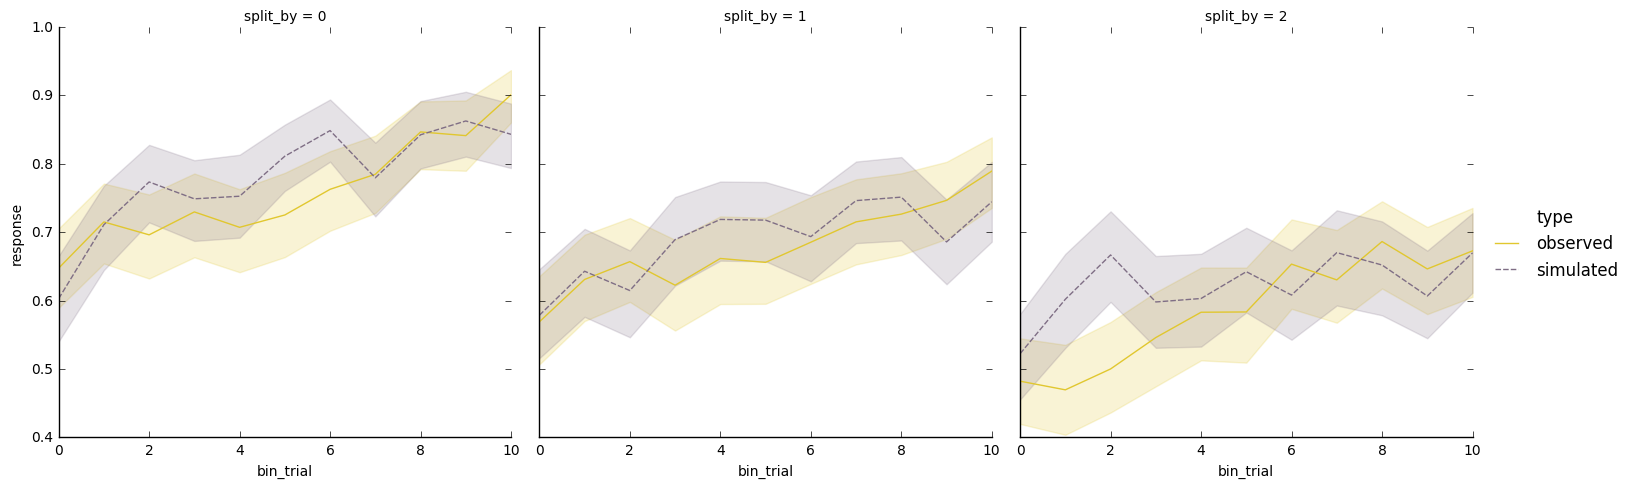

In [5]:
#plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy. 
g = sns.relplot(x='bin_trial',y='response',hue='type',col='split_by',kind='line',style='type',data=ppc_data,palette="Set1_r")
g.set(ylim=(0.4,1),xlim=(0, 10))
g.savefig('PPCchoice.png')

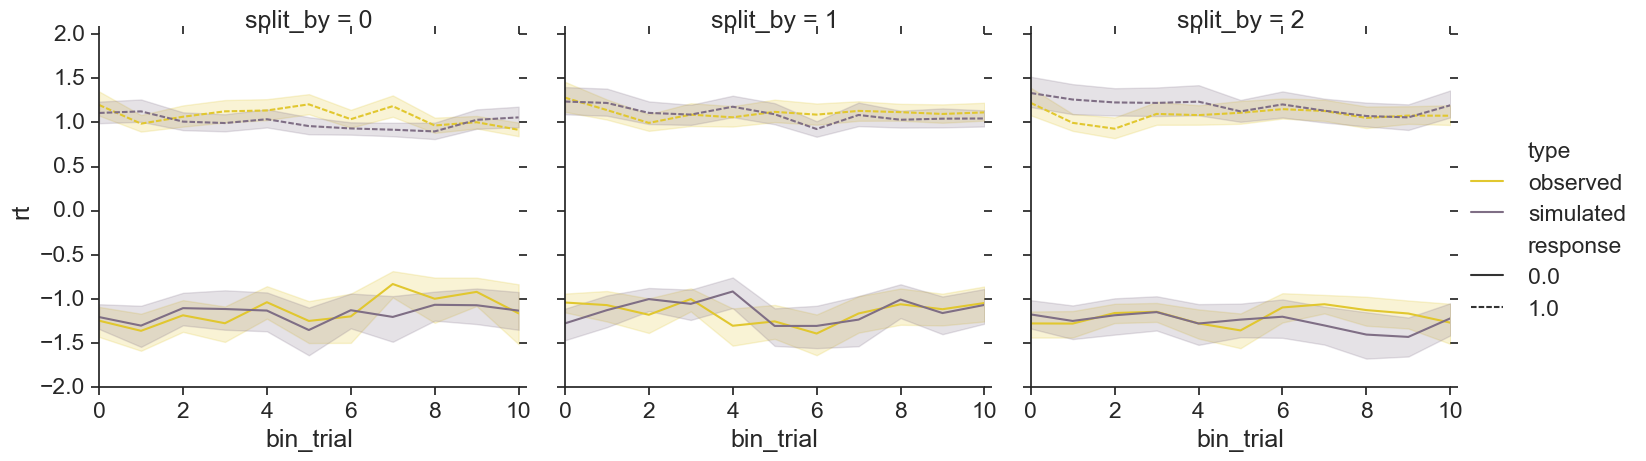

In [30]:
#plotting evolution of RT for best (positive RT) and worst (negative RT) option across learning for observed and simulated data.
g = sns.relplot(x='bin_trial',y='rt',hue='type',col='split_by',kind='line',style='response',data=ppc_data,palette="Set1_r")
g.savefig('PPCrt.png')

## 8. Parameter recovery
To validate the RLDD model we ran a parameter recovery study to test to which degree the model can recover the parameter values used to simulate data. To do this we generated 81 synthetic datasets with 50 subjects performing 70 trials each. The 81 datasets were simulated using all combinations of three plausible parameter values for decision threshold, non-decision time, learning rate and the scaling parameter onto drift rate. The following plots show that the absolute error between estimated and simulated parameters in general are small.

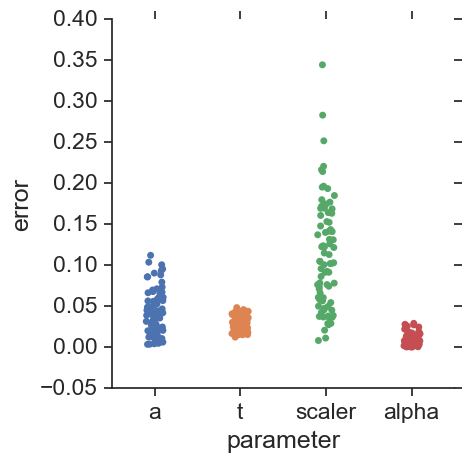

In [9]:
#absolute error of estimated parameter values relative to values used to simulate data. one point represents the group error for one synthetic dataset.
recovery = hddm.load_csv('data/recovery_error.csv')
g = sns.catplot(x='parameter',y='error',hue='parameter',data=recovery)

__We can also plot simulated together with the estimated values to see if there are any values that are more difficult to recover than others.__

In [8]:
param_recovery = hddm.load_csv('data/recovery_sim_est.csv')

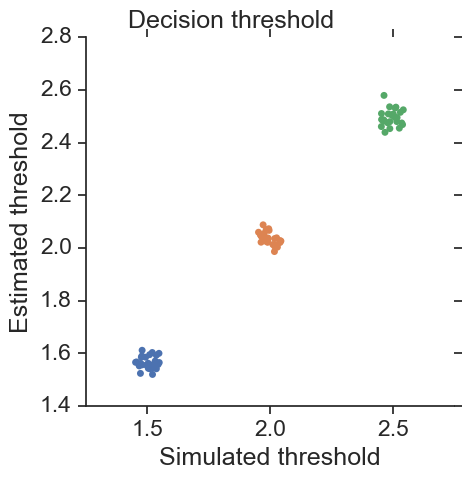

In [9]:
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.catplot(x='a',y='e_a',data=param_recovery)
g.fig.suptitle("Decision threshold")
g.set_axis_labels("Simulated threshold", "Estimated threshold")
g.savefig('Threshold_recovery.png')

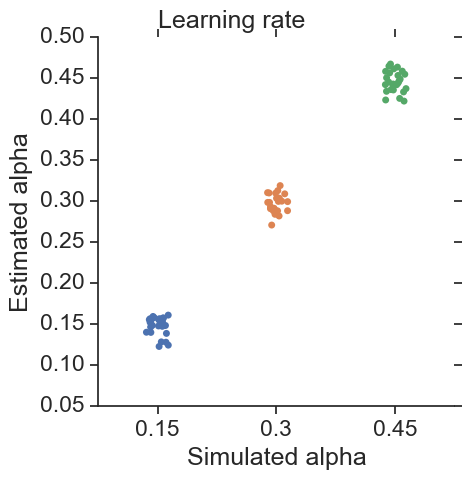

In [10]:
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.catplot(x='alpha',y='e_alphaT',data=param_recovery)
g.fig.suptitle("Learning rate")
g.set_axis_labels("Simulated alpha", "Estimated alpha")
g.savefig('Alpha_recovery.png')

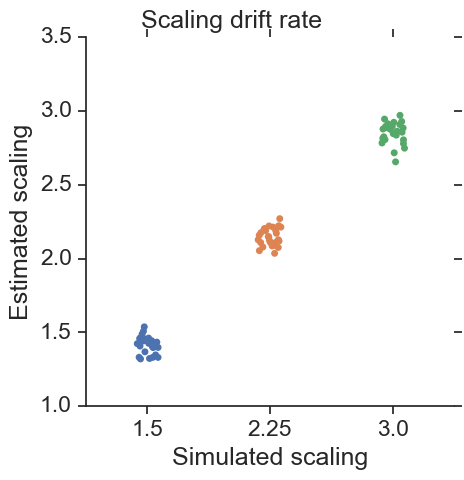

In [12]:
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.catplot(x='scaler',y='e_v',data=param_recovery)
g.fig.suptitle("Scaling drift rate")
g.set_axis_labels("Simulated scaling", "Estimated scaling")
g.savefig('Scaler_recovery.png')

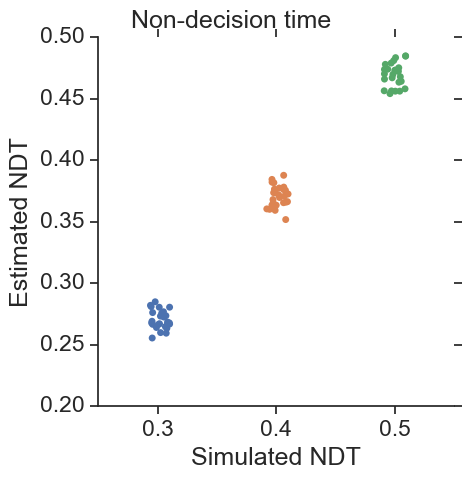

In [6]:
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.catplot(x='t',y='e_t',data=param_recovery)
g.fig.suptitle("Non-decision time")
g.set_axis_labels("Simulated NDT", "Estimated NDT")
g.savefig('NDT_recovery.png')

## 9. Separate learning rates for positive and negative prediction errors
Several studies have reported differences in updating ofexpected rewards following positive and negative prediction errors, which is hypothesized to be caused by the differential roles of striatal D1 and D2 dopaminereceptors in separate corticostriatal pathways. To model assymetric updating rates for positive and negative you can include dual_alpha in the model:

In [10]:
#run the model by calling hddm.HDDMrl (instead of hddm.HDDM for normal model)
m = hddm.HDDMrl(data,include='dual_alpha')
#set sample and burn-in
m.sample(2000,burn=1000,dbname='traces.db',db='pickle')
#print stats to get an overview of posterior distribution of estimated parameters
m.print_stats()

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2001 of 2000 complete in 718.7 sec

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                         mean         std        2.5q        25q        50q        75q      97.5q       mc err
a                     1.91405   0.0669517     1.79112    1.86597    1.91683    1.95787    2.05087   0.00233208
a_std                0.442331   0.0559837    0.351996   0.401096   0.435914   0.474669   0.566416   0.00248515
a_subj.1              2.34925   0.0826451     2.20163    2.29181    2.34043    2.40265    2.52054   0.00436033
a_subj.2              1.89795    0.128965     1.66731    1.80375    1.89547     1.9865    2.15907   0.00496996
a_subj.3              2.17161     0.10889     1.98204    2.09517     2.1628    2.24631    2.39967   0.00504489
a_subj.4              2.10669   0.0523645     2.01052     2.0695    2.10472    2.13987    2.21297   0.00185631
a_subj.5              1.62079   0.0820523     1.47907    1.56426    1.61438    1.67504    1.78675   0.00348439
a_subj.6              2.50955   0.0909957     2.33334    2.44421    2.51188    2.56889    2.68569   0.00387738
a

__To interpret the parameter estimates for alpha and dual_alpha you have to transform them with the inverse logit where learning rate for negative prediction error is alpha and learning rate for positive prediction errors is alpha+dual_alpha. For this dataset the learning rate is estimated to be higher for positive than negative prediction errors.__

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


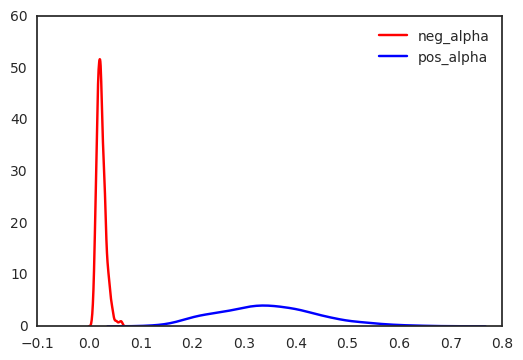

In [11]:
#plot alpha for positive and negative learning rate
traces = m.get_traces()
neg_alpha = np.exp(traces['alpha'])/(1+np.exp(traces['alpha']))
pos_alpha = np.exp(traces['alpha']+traces['dual_alpha'])/(1+np.exp(traces['alpha']+traces['dual_alpha']))
sns.kdeplot(neg_alpha, color='r', label="neg_alpha")
sns.kdeplot(pos_alpha, color='b', label="pos_alpha")

## 10. depends_on vs. split_by
HDDMrl can be used to estimate separate parameters just as in the standard HDDM. But in RL you typically estimate the same learning rates and inverse temperature across conditions. That's one reason why you have to specify condition in the split_by-column instead of depends_on. The other is that by using depends_on you separate the data, which means that expected rewards don't get updated properly. But depends_on is still useful, for example if you want to estimate the effect of group on parameters. As an example we can simulate a dataset with two groups that have different decision thresholds:

In [12]:
data1 = hddm.generate.gen_rand_rlddm_data(a=1,t=0.3,alpha=0.2,scaler=2,p_upper=0.8,p_lower=0.2,subjs=20,size=50)
data1['group'] = 'group1'
data2 = hddm.generate.gen_rand_rlddm_data(a=2,t=0.3,alpha=0.2,scaler=2,p_upper=0.8,p_lower=0.2,subjs=20,size=50)
data2['group'] = 'group2'
group_data = data1.append(data2)
m = hddm.HDDMrl(group_data,depends_on={'v':'group','a':'group','t':'group','alpha':'group'})
m.sample(2000,burn=1000,dbname='traces.db',db='pickle')
m.print_stats()

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 245.6 sec

/Users/madslundpedersen/anaconda/envs/rlddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                            mean         std       2.5q        25q        50q        75q       97.5q       mc err
a(group1)                1.03575   0.0558022    0.93186   0.999441    1.03305    1.06908     1.15794   0.00210647
a(group2)                2.01236   0.0626676    1.89011     1.9683    2.01335    2.05488     2.13329     0.002734
a_std                   0.229062   0.0344462   0.168997   0.204004   0.225998   0.251662    0.301774   0.00191194
a_subj(group1).0        0.890187   0.0605027   0.784945   0.846908   0.885482   0.932441     1.02059    0.0025685
a_subj(group1).1        0.980806   0.0672934   0.865714   0.931119   0.974625    1.02579     1.12269   0.00322439
a_subj(group1).2         1.51261     0.11224    1.30619    1.43333    1.50327    1.58297     1.75281   0.00585143
a_subj(group1).3         1.18114   0.0775818    1.03404    1.12878     1.1785    1.23422     1.33638   0.00326254
a_subj(group1).4        0.985485   0.0701897   0.859978    0.93617   0.980038    1.03003

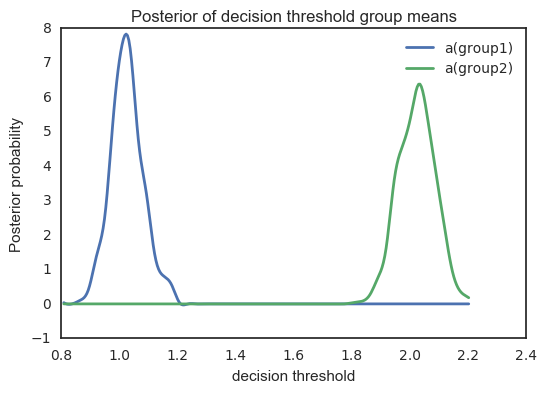

In [13]:
#the plot shows that the model was able to recover the different decision threshold across groups.
a_group1, a_group2 = m.nodes_db.node[['a(group1)', 'a(group2)']]
hddm.analyze.plot_posterior_nodes([a_group1, a_group2])
plt.xlabel('decision threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')